# Problem Set 5

Written by Jess Breda & Max Argon with inspiration from work by Yotam Sagiv.

A note on grading: You will be graded on correctness and also clarity. That means code should be readable and commented. For all plots, make sure to label your axes.


## Part 1: Encoding & Decoding models [15]

As discussed both in lecture and in precept, encoding models are a way of mapping some natural quantity into a particular representation for that quantity. In neuroscience, this is often a mapping from some natural space into either spikes or spike rates (e.g. the orientation of a light bar into spike rates for V1 simple cells). In a sense, you can think of them as following the actual order of information-processing in the brain -- stimuli go in, resulting in spikes or changes in spike rates.

This provides us with a way of rigorously and explicitly constructing theories of neural function. Committing to a formal mathematical model allows us to use a variety of computational tools to test our understanding of the dynamics underlying a neural population (e.g. how it responds to stimuli, how any relevant input affect behavioural output, etc.).


### Building a hippocampal place cell model

To illustrate all of these ideas, we're going to simulate the activity of some "place cells". Our encoding model will be as follows: we assume that the tuning curve of each neuron has a Gaussian shape, with height 15 and variance 1, centered over its preferred location. 

That is, the firing rate of neuron $i$ at location $x$ is: 

$$r(x, \mu_i) = k \cdot \text{normpdf}(x ; \mu_i, 1)$$ 

Here, $\mu_i$ is the preferred location of the neuron, $\text{normpdf}(x ; \mu, \sigma^2)$ indicates the normal distribution with mean $\mu$ and variance $\sigma^2$ evaluated at $x$, and $k$ is a scale factor that we throw in front to make the height 15. 

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
sns.set_context('notebook')

### Question 1.1 [1]

Encoding models map an input quantity to an output representation. For this example, what is the input quantity? What is the output representation?

><font color="firebrick">Answer here

### Question 1.2 [1]
Implementing the equation above, write a function that evaluates the firing rate of a neuron at a location $x$, given its preferred location $\mu$. Please documents your inputs & returns.

In [ ]:
## Code here ## 

### Question 1.3 [2.5]
Using this function, plot the tuning curves of 21 independent neurons that have preferred locations on all the integers between -10 and 10 (inclusive). Plot all the tuning curves on the same x-axis.

In [ ]:
## Code here ## 

Now that we have the ability to compute firing rates for our 21-neuron population, let's simulate some activity from them. This requires us to translate the firing rates computed by our encoding model into spike counts. 

A popular method of doing this is by sampling from the Poisson distribution. As discussed in precept, the Poisson distribution tells us the probability of a particular number of events occurring in a time period, given a constant rate. In our case, the events are the number of spikes generated by a neuron, given the rate computed by our encoding model. 

That is, we will sample a spike count $c_i$ for neuron $i$ at location $x$: $c_i \sim Pois(r(x, \mu_i))$

Recall that $r(x, \mu_i)$ is the firing rate of a neuron with preferred location $\mu_i$ at location $x$.

### Question 1.4 [2.5]

For each neuron created in 1.3, sample a spike count assuming a location of $x=-1$. Plot the population response on one axis as a function of each neuron's preferred location. Hint: remember that $r(x, \mu_i) = k \cdot \text{normpdf}(x ; \mu_i, 1)$ ie use the function you already wrote to help you here.




In [ ]:
## Code here ## 

### Decoding from hippocampal place cells

Up until now, we've been working with encoding -- that is, taking some natural quantity (such as the orientation of a light bar for V1 simple cells) and converting it to spikes. In this section we'll look at how we can invert this process (e.g. estimating the orientation of a light bar by looking at the spikes encoding it). This is called decoding.

As neuroscientists, we principally care about decoding for two reasons. It is a way to validate our encoding models: if our encoding model is good, we should be able to recover the input used to generate a neural response by directly inverting the encoding model. More generally, however, decoding is a way of testing whether a given neural code carries a particular type of information. For example, if we can reliably decode an animal's velocity from a certain neural population, this tells us that those neurons carry structured information about velocity.


There are a variety of different decoding methods, each with a different set of assumptions and accepted risk factors with respect to the encoding model. For example, winner-take-all (WTA) decoding returns the stimulus preferred by the **most active** neuron in the population. 

That is: 

$$ x_{WTA} = \mu_j \\j = \arg\,\max_{i} r_i$$

### Question 1.5 [2]

Write a function that implements a WTA decoder for the population response $\vec{r}$ of your 21 place cells. Then, perform WTA on your output from your simulation in 1.4

In [ ]:
## Code here ## 

The WTA decoder does not really make great use of the encoding model. In fact, it doesn't really use it at all. If we would like to use our encoding model, we should make the following observation: our model tells us the probability of a neuron emitting a particular response, given an input location. That is, it gives us $P(c_i~|~\mu_i,~x)$. Since we're assuming neural responses are independent, then the probability of the whole population response is just the product of the individual neural response probabilities: $P(\vec{r}~|~\vec{\mu},~x) = \prod_{i=1}^{21}P(c_i~|~\mu_i,~x)$.

In maximum-likelihood estimation (MLE), we are looking for the $x$ that maximizes the likelihood function -- i.e., the $x$ that has the highest $P(\vec{r}~|~\vec{\mu},~x)$. There are a number of sophisticated ways we can find it (this is a field of research called "optimization"), but for now, we will do grid search. In grid search, we divide the stimulus domain into very small steps and then individually test each step to look for the best one.

Finally, a note on implementation. When doing MLE we are looking for the maximizer $x$ of the likelihood function $P(\vec{r}~|~\vec{\mu},~x) = \prod_{i=1}^{21}P(c_i~|~\mu_i,~x)$. In practice, we will often choose to find the maximizer $x$ of the **log** of the likelihood (log-likelihood). The reason for this is that in the standard likelihood computation, we have to compute this product $\prod_{i=1}^{21}P(c_i~|~\mu_i,~x)$ -- but unfortunately products of probabilities tend to get small very quickly and computers have issues dealing with very small quantities. Instead, taking the logarithm allows us to compute $\log P(\vec{r}~|~\vec{\mu},~x) = \sum_{i=1}^{21}\log P(c_i~|~\mu_i,~x)$. Since this is a sum, and due to the properties of the logarithm function, the log-likelihood becomes small at a **much** slower rate than the standard likelihood function. Since the maximizer for both will be the same, in practice people almost always do MLE with the log-likelihood than the likelihood for non-trivial datasets. (Note, this is not a trivial idea, but it is an important practical one. If you don't understand why this works, you should try to figure it out by experimenting with some likelihood models and seeing what happens with a lot of data doing MLE over likelihood and log-likelihood.) 

### Driver Functions

Below are the two functions you need to implement an MLE decoder for the population response $\vec{r}$ of your 21 place cells. This operates through grid search -- i.e. by dividing the stimulus domain $[-10, 10]$ into very small steps (of size $dx = 0.1$), evaluating the log-likelihood at every location, and then returning the one that had the highest probability.


In [ ]:
def poission_log_likelihood(current_loc, preferred_loc, count):
    """Function that determines the log likelihood of observing spike counts,
    given a stimulis current location and a neuron's preferred location
    inputs:
        - current_loc (int): current location of a stimulus
        - preffered_loc (int): preferred location of a neuron
        - counts (arr): encoded spike count values sampled from a poiss distribution 
    
    outputs:
        - log_likelihood (arr): log likelihood for each count passed into the function
    -------------
    Usage example
    -------------
    poisson LL of neuron w/ pref loc of -4 firing 0 spikes when the current location is -1:
    poission_log_likelihood(-1, -4, 0)
    """
    
    # create poisson distribution for one current and prefered location, for one neuron.
    # simulate_firing_rate needs to be filled in with the name of the function from part 1.1
    #  Determine probability of seeing count x with probability mass function
    LLH = (np.log(poisson(simulate_firing_rate(current_loc, preferred_loc)).pmf(count)))
           
    return LLH

def log_likelihood_grid_search(grid, preferred_locs, counts):
    """
    Function performs log likelihood over a grid of stimulus locations 
    and returns maximum likelihood location.
    
    inputs:
        - grid (arr): dimensions to perform grid search on with log likelyhood
        - preffered_loc (arr): preferred locations of neurons to test
        - counts (arr): encoded spike count values sampled from a poiss distribution 
        *note counts and preffered_loc must have same length
    
    outputs:
        - MLE_stim: stimulus location that had the highest likelihood via log MLE
    -------------
    Usage example
    -------------
    NOTE YOU WILL NEED TO CHANGE STEP SIZE TO BE 0.1 once you get everything running
    grid = np.arange(-10,10.01,1) # initialize grid
    stimuli = np.linspace(-10,10,21)
    spike_counts =  [1, 2, 7, 13, 6, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    """ 
    #create empty grid to push to
    LLHs = -np.ones([len(preferred_locs), len(grid)])
    
    #iterate over each stimulus and sampled count to calculate LLHs across the location grid
    for stim_idx in range(len(preferred_locs)):
        for grid_idx,grid_loc in enumerate(grid):  
            LLHs[stim_idx,grid_idx] = poission_log_likelihood(grid_loc, preferred_locs[stim_idx], counts[stim_idx])
    
    #sum each neuron across the grid (joint probability)
    LLH_by_stim = np.sum(LLHs, axis = 0)
    
    #find the grid location with highest probability
    MLE = np.argmax(LLH_by_stim)
    
    #return it
    return grid[MLE]


# Question 1.6 [3]

Using the functions above run an experiment evaluating the decoding methods. 

Repeat the following **100 times**: sample a location  𝑥  uniformly from -10 to 10. Simulate the population response  𝑟⃗   to it, and then compute a location estimate from that response using the two decoders you implemented above. (you don't need to print any output yet)

In [ ]:
## Code here ## 

### Question 1.7 [3]

Write of find a function that can compute mean sqaure error on your your two outputs. Make a bar graph showing the average MSE for each decoder with 95% confidence intervals (or some form of variance). Which method is better for these data?

><font color="firebrick">Answer here

In [ ]:
## Code here ## 

## Part 2: Setting up a bump attractor connectivity matrix [7.5]

---



In this problem, you will set up a simulated network's connectivity matrix according to a "connectivity kernel." A connectivity kernel is a pattern of weights that is applied identically to each neuron. For example, you might say that each neuron excites neurons close to it and inhibits neurons far from it. The kernel in this case is precisely the pattern of "local excitation, distal inhibition."

Bump attractor networks are set up in exactly this fashion (i.e. by specifying a kernel and then applying it to each neuron). In this section, you will set up a bump attractor network and simulate its activity.

### Question 2.1 [2] 
Bump attractors employ a connectivity kernel composed of local excitation and global inhibition (i.e. neurons will excite their neighbours and receive global inhibitory drive). The function below accepts two indices `i, j` and returns the synaptic weight between them according to this rule. Use this function to set up a matrix $T$ containing all the synaptic weights for the bump attractor network with 10 neurons.

In [ ]:
# Given two neuron idxs (i, j), return the strength of the connection from 
# j to i as a function of some parameters. Broadly, this implements a kernel
# with local excitation and distal inhibition. 
def bump_synaptic_weights(i, j, w_e=1.4, sigma_e=4, g_i=0.4):
    # Neurons are not connected to themselves
    if i == j:
        return 0
    
    # Approximately a Gaussian excitation envelope
    scale_factor = w_e / sigma_e
    power = (-(i - j) ** 2) / sigma_e
    
    return scale_factor * np.exp(power) - g_i


## Write code to create T matrix here ## 

### Question 2.2 [3] 
Plot the resultant weight matrix.  Do you notice any patterns? Why are they there? You should make reference to the idea of a connectivity kernel to answer this question.

><font color="firebrick">Answer here

In [ ]:
## Plot weight matrix here ## 

### Question 2.3 [2.5]
As stated earlier, bump attractor models are essentially models of place cells. However, let's say you wanted to create a **grid** cell network, in which there is not a singular bump of activity, but a set of multiple bumps with regular intervals between them. How would you adjust the connectivity kernel above in order to create this pattern of activity? You may answer this question by copying, pasting, and adjusting the code for `bump_synaptic_weights` or by writing below qualitatively.

><font color="firebrick">Answer here

## Part 3: Assessing the effect of noise on spike sorting [15]

**Tetrodes** are one of the major tools in the physiologist's toolkit. These devices consist of four electrodes that can simultaneously record from nearby areas of the brain. In this exercise, you will be exploring how to identify neurons in a tetrode recording through **spike sorting**. In addition, you will assess how the quality of your results depend on noise and the number of recording electrodes.

To get started, let's generate some synthetic data. Our recordings will be based on three waveforms corresponding to three distinct neurons. These waveforms are displayed below. Note that the sampling frequency is 10kHz. 


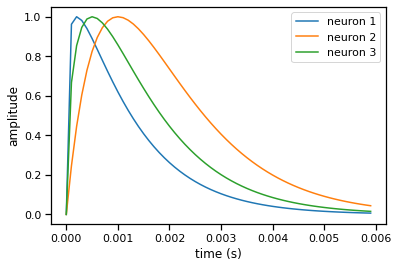

In [ ]:
import numpy as np
import random
from matplotlib import pyplot as plt 
from scipy.stats import gamma, zscore

random.seed(1)

# Create spike waveforms
s1 = [gamma.pdf(0.01*x, 1.2, loc=0, scale=0.1) for x in range(60)]
s2 = [gamma.pdf(0.01*x, 2, loc=0, scale=0.1) for x in range(60)]
s3 = [gamma.pdf(0.01*x, 1.5, loc=0, scale=0.1) for x in range(60)]
s1/=max(s1)
s2/=max(s2)
s3/=max(s3)

# Plot waveforms 
sf = 10e3
time = np.arange(60)/sf
plt.plot(time,s1,label='neuron 1')
plt.plot(time,s2,label='neuron 2')
plt.plot(time,s3,label='neuron 3')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.legend()
plt.show()

The function defined below uses these waveforms and a noise term to generate voltage records. Note that the voltage amplitude for each neuron is scaled to reflect different positions of the electrodes relative to the recorded neurons (i.e. if the neurons are closer to the electrodes, their amplitudes will be larger).

In [ ]:
def generateRecords(nChannels,noise,manualStarts=None):
  '''Create multi-channel field recording.
  ------
  Inputs
  ------
  nChannels (int): number of recording channels
  noise (float): noise coefficient 
  manualStarts (list): list of spike start times. If not provided, will compute these.
  -------
  Outputs
  -------
  records (array): multi-channel recording 
  starts (array): spike start times 
  '''
  nSamps= 100000 # number of voltage samples 
  records = [] # contains recording channels 
  noise = noise*np.random.normal(size=nSamps) # recording noise
  scalings = [(random.uniform(0,1),random.uniform(0,1),random.uniform(0,1)) \
              for i in range(nChannels)] # scales waveform amplitudes 
  
  # Don't compute spike times if they are already provided  
  if manualStarts:
      starts = manualStarts
      
  else:
      starts = [np.sort(np.random.randint(0,1600,20)*60) \
                for i in range(3)] # spike start times
      
  chunks = [[np.array([np.arange(s_i,s_i+60) for s_i in s[1:-1]])] \
            for s in starts] # spike events
  
  # Generate record for each electrode 
  for scale in scalings:
      c1,c2,c3 = scale # scaling coefficients 
      z = np.zeros(nSamps) # voltage trace
      z[tuple(chunks[0])] = s1*c1
      z[tuple(chunks[1])] = s2*c2
      z[tuple(chunks[2])] = s3*c3
      z = z + noise # add noise 
      records.append(z)
      
  records = np.array(records)
  
  return records, starts


### Question 3.1 [1]
Using this function, generate a plot of 10s of synthetic data for a tetrode (4 channels) with `noise = 0.5`  

In [ ]:
## Code here ## 

### Question 3.2 [1.5]
Our goal is to identify different neurons in this noisy four-channel recording. To do this, we first need to extract spikes from the records. The function segmentSpikes extracts spikes and outputs an array "segSpikes," where each row corresponds to an extracted spike time series. 

In [ ]:
def segmentSpikes(records,thresh,skip,manualTimes=None):
  '''Create multi-channel field recording.
  ------
  Inputs
  ------
  records (array): voltage recordings for all channels 
  thresh (list): z-score threshold for spike acceptance 
  skip (int): minimum time bins between consecutive spikes 
  manualTimes (list): list of spike start times. If not provided, will compute these.
  -------
  Outputs
  -------
  segSpikes (array): segmented spikes
  spikeTimes (array): spike start times 
  '''
  maxProject = np.max(records,axis=0) # max-projection of channels 
  locs = np.argwhere(zscore(maxProject) > thresh).flatten() # candidate spike positions
  spikeTimes = [0] # intialize list of spike times

  # Use manual times if provided. Otherwise, find spike times
  if manualTimes:
      spikeTimes = manualTimes
      
  else:
      for l in locs:
          if l > (spikeTimes[-1] + skip):
              spikeTimes.append(l)
      
  # Segment spikes
  segSpikes = np.array([maxProject[l-10:l+30] for l in spikeTimes[1:] \
                          if len(maxProject[l-10:l+30])==40])
              
  return segSpikes,spikeTimes

        

Generate a plot of your extracted spikes from the question above. How many different waveforms do you see? Why does this make ense?

**Hint**: A threshold of 2.56 and a skip value of 60 work well.

><font color="firebrick">Answer here

In [ ]:
## Plotting code here ## 

### Question 3.3 [3]

Now comes the fun part. Write a function that takes your "segSpikes" array and sorts these spikes into different groups. At a minimum, your function should return the predicted label for each extracted spike and generate a plot of the different spike waveforms and a plot of the first two principal components color-coded by group identity.

**Important:** Even though we know we are recording three neurons, do not make any assumptions about the number of groups to cluster: you should find a way to test a set of clusters and then quantitatively determine the optimal number. 

**Hint:** You may find PCA, KMeans, and silhouette_score code from sklearn to be helpful here. 

In [ ]:
## Code here ## 

### Question 3.4 [3]
You will now assess the effect of noise on the quality of your spike sorting. (1) Write a function called "analyze_noise" that takes an array of noise levels `(np.linspace(0.005, 0.4, 6))` and returns a metric that quantifies the grouping quality. (2) Plot that metric as a function of different noise levels. (3) Your function should also generate a plot of the color-coded waveforms and PC1/2 for each noise level (or call a second function that makes those plots).

**Hint:** If you are using KMeans to cluster your data, the silhouette score for each cluster assignment is a natural way to quantify sorting quality. In addition, reducing the dimensionality of your data (to say, 2 dimensions) will help you directly observe how noise infleunces your clusters. 

**Hint:** The way the function (`generateRecords`) was written for you above means that you should use the spike times from the first (lowest noise) iteration for the remaining interations. In other words, extract "starts" from generateRecords and "spikeTimes" from segmentSpikes for the lowest noise case. For all subsequent noise levels, feed "starts" into generateRecords and "spikeTimes" into segmentSpikes. 


In [ ]:
## Code here ## 

### Question 3.5 [2] 
Interpret your results from the noise analysis. 

**(1)** How does noise affect the quality of your spike sorting algorithm? Be sure to use your generated graphs and quantitative metric to support your argument. 

><font color="firebrick">Answer here

**(2)** List at least one way you may be able to improve the signal/noise ratio during extracellular recordings. 

><font color="firebrick">Answer here

### Question 3.6 [2]
Finally, you will assess the performance of your spike sorting algorithm as a function of the number of recorded channels. Write a function called "analyze_channels" that takes as input (1) a list containing the number of channels (between 2 and 10) and (2) a noise coefficient of 0.3. For each channel number, you should average your quality metric across at least 10 iterations in order to best observe the trend. Plot the average quality metric as a function of number of recorded channels.  

**Hint:** using a tqdm progress bar in your first for loop may be helpful here.

In [ ]:
## Code here ## 

### Question 3.7 [2.5]
Interpret your results from the channel analysis. 

**(1)** Does increasing the number of channels improve your spike sorting algorithm according to your quality metric? Explain your observations.

><font color="firebrick">Answer here

**(2)** How do you think your results would change if the noise level were much lower? Justify your answer. You may experiment with different noise levels in your "analyze_channels" function. 

><font color="firebrick">Answer here